# Satellite and Surface Obs

By: Kevin Goebbert

Combining both satellite and surface observations is easy with the simplified declarative syntax available in MetPy. This example uses a bit of Siphon to help get current observations and satellite retrievals.

As demonstrated at AMS 2020 Annual Meeting.

In [1]:
from datetime import datetime, timedelta

from metpy.io import metar
from metpy.plots.declarative import *
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr

A nice definition to help get the most recent satellite observations.

In [2]:
def get_goes_image(date=datetime.utcnow(), channel=8, region='CONUS'):
    """Return dataset of GOES-16 data."""
    cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                     'CloudAndMoistureImagery/{}/Channel{:02d}/{:%Y%m%d}/'
                     'catalog.xml'.format(region, channel, date))

    # Get data from about an hour ago.
    if len(list(cat.datasets)) < 10:
        file_num = len(list(cat.datasets))
    else:
        file_num = 10
    ds = cat.datasets[file_num]  # Get most recent dataset
    ds = ds.remote_access(use_xarray=True)
    return ds

## Get Satellite data

Use data available on the UCAR THREDDS Data Server to get a recent GOES East IR satellite imagery from Channel 14.

In [3]:
# Get IR Satellite data
ds = get_goes_image(datetime.utcnow(), channel=14)

In [4]:
# Set map time from Satellite Data
vtime = ds.time.values.astype('datetime64[ms]').astype('O')

## Get METAR Observations

Use available METAR data, also obtained from the UCAR THREDDS Data Server, download and parse using the MetPy METAR parsing functionality.

In [5]:
# Get Surface Data from UCAR
cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

time_idx = list(cat.datasets).index(f'metar_{vtime:%Y%m%d}_{vtime:%H}00.txt')

metar_df = cat.datasets[time_idx]
metar_df.download(f'../../data/{metar_df.name}')

# Parse METAR data with MetPy
df = metar.parse_metar_file(f'../../data/{metar_df.name}')

## Convert Variable

Typically we plot surface temperature in the Fahrenheit scale in the U.S., so we are going to use MetPy unit functionarlity to convert the METAR air temperature (which is in Celsuius) to Fahrenheit and add it to the dataFrame. Subset data to be only over CONUS to help with plotting obs on the satellite projection.

In [6]:
# Convert temperature to degF and store in dataframe
df['tmpf'] = (df.air_temperature.values * units(df.units['air_temperature'])).to('degF')

# Subset for data only over CONUS (for plotting ease)
df = df[(df.latitude.values > 25) & (df.latitude.values < 60)]
df = df[(df.longitude.values < -60) & (df.longitude.values > -150)]

## Create Plot

Use the declarative syntax from MetPy to plot both the METAR surface temperatures and the GOES EAST IR Satellite Imagery.

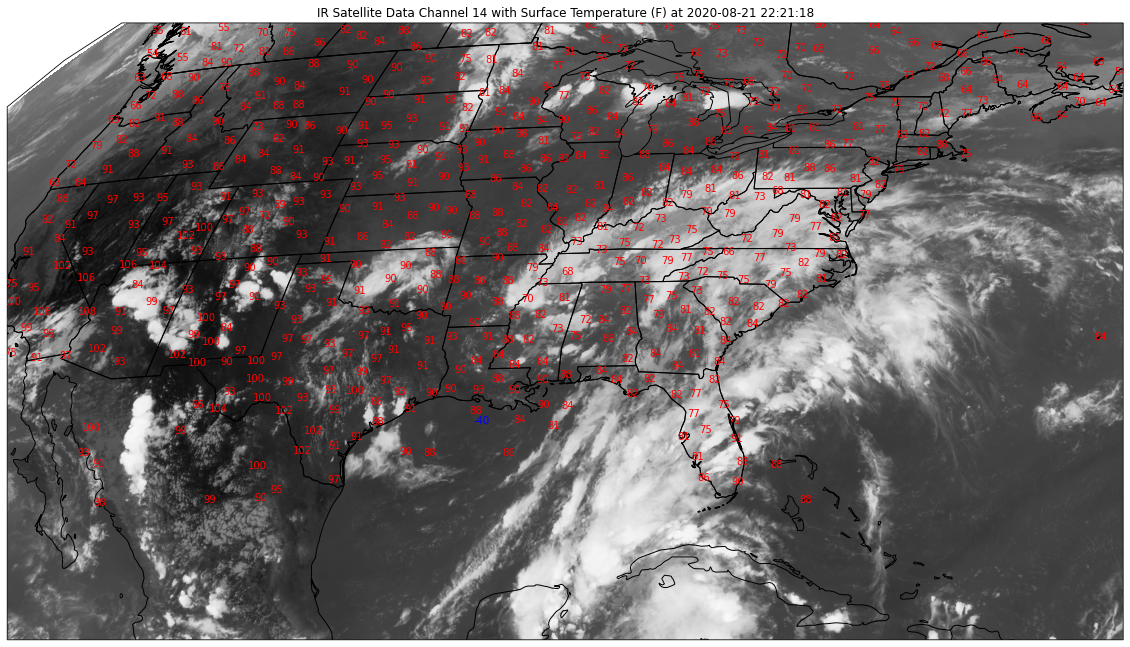

In [7]:
# Create Plot

# Plot all obs greater than 32F red
obs = PlotObs()
obs.data = df[df.tmpf > 32]
obs.time = vtime
obs.time_window = timedelta(minutes=30)
obs.level = None
obs.fields = ['tmpf']
obs.colors = ['red']
obs.reduce_points = 0.7

# Plot all obs less than 32F blue
obs2 = PlotObs()
obs2.data = df[df.tmpf <= 32]
obs2.time = vtime
obs2.time_window = timedelta(minutes=30)
obs2.level = None
obs2.fields = ['tmpf']
obs2.colors = ['blue']
obs2.reduce_points = 0.7

# Add the IR image to the plot
img = ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
img.colormap = 'Greys'

# Bring plots together in a map panel and add a title
panel = MapPanel()
panel.area = [-112, -65, 20, 50]
panel.title = f'IR Satellite Data Channel 14 with Surface Temperature (F) at {vtime}'
panel.layers = ['coastline', 'borders', 'states']
panel.plots = [img, obs, obs2]

# Place the panel on a figure
pc = PanelContainer()
pc.size = (20, 20)
pc.panels = [panel]
pc.show()